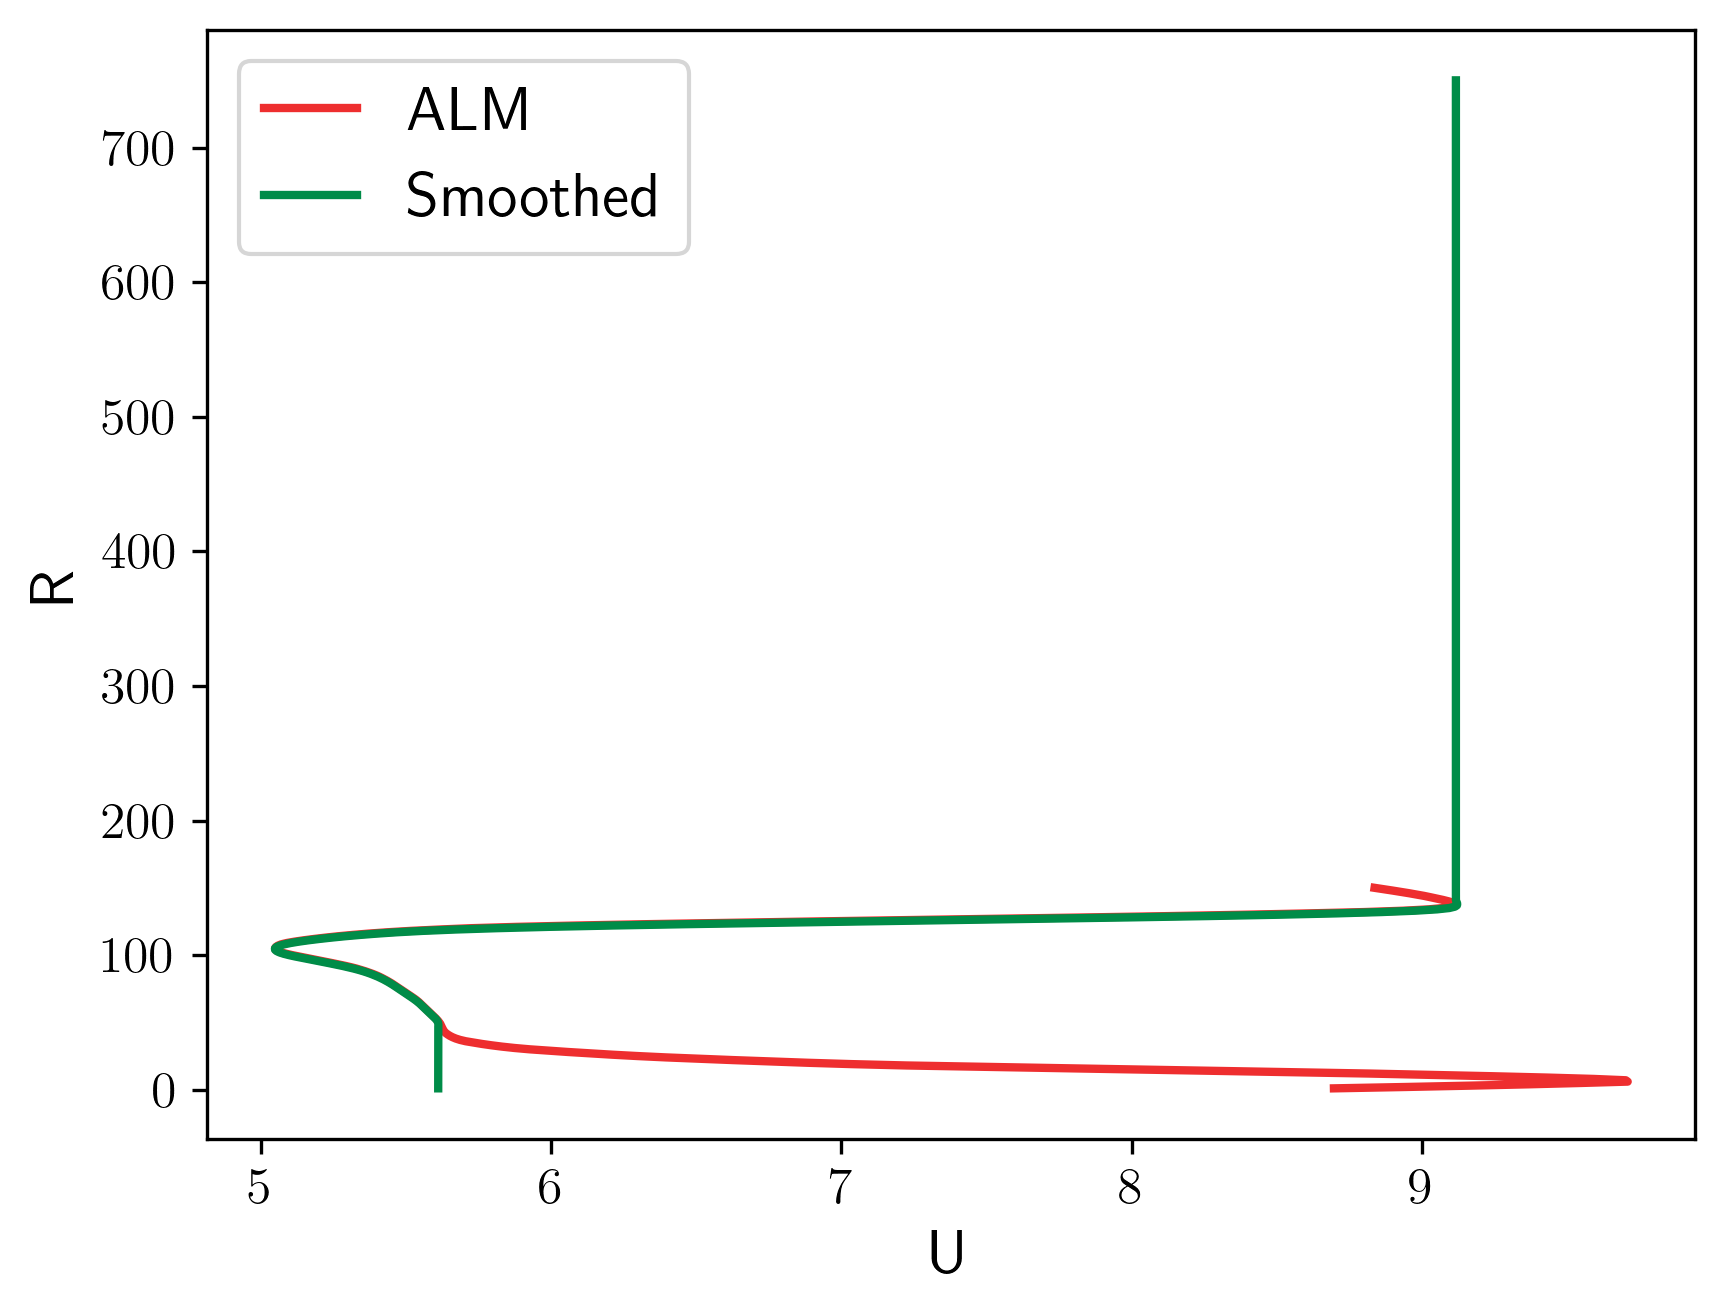

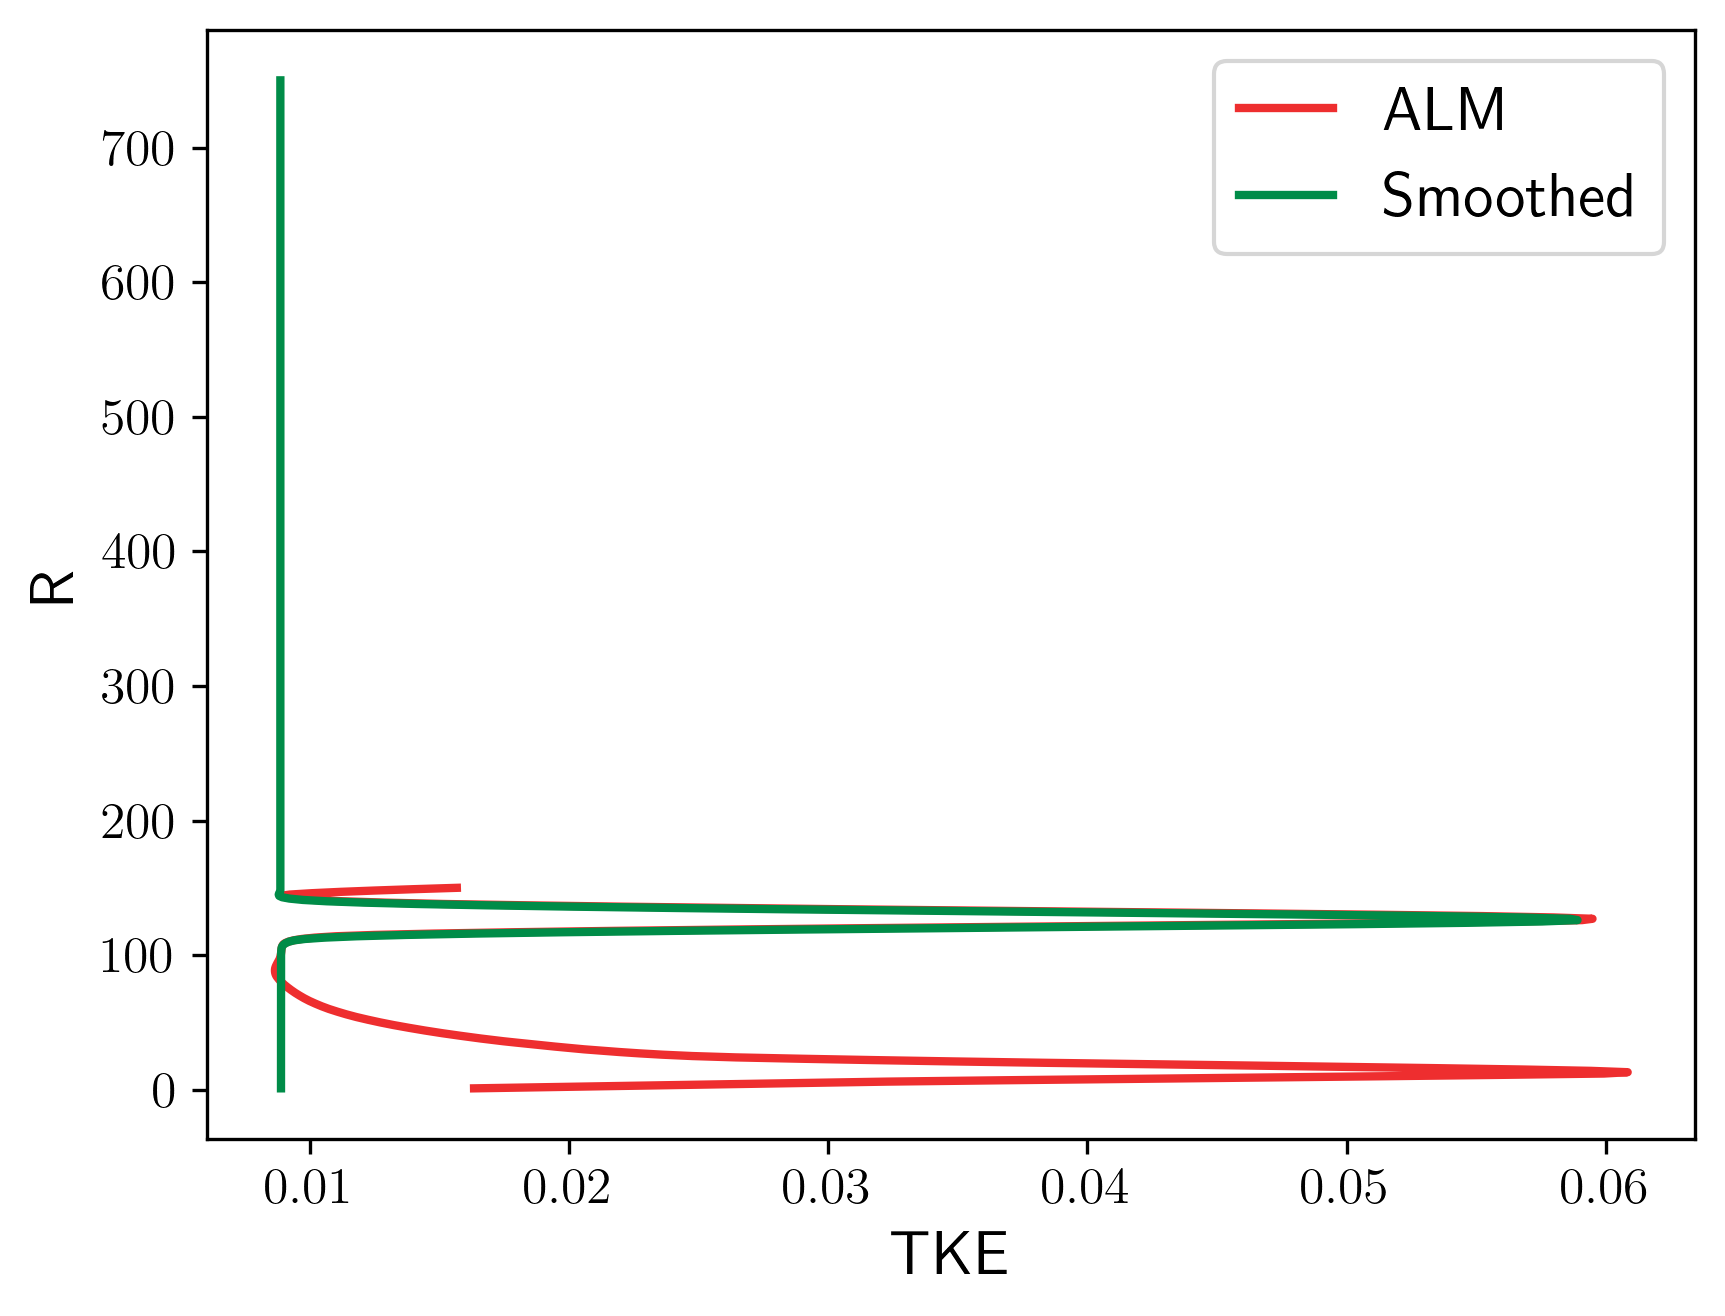

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter

import SANDLST
import SANDRANS


def tanhUprofile(r, U0, U1, rdelta, delta):
    return 0.5 * (U1 - U0) * (1.0 + np.tanh((r - rdelta) / delta)) + U0

# Set RANS parameters
params = {
    "Re": 1.0 / 1.47e-5,
    "C_mu": 5.48 ** (-2),
    "C_1e": 1.176,
    "C_2e": 1.92,
    "sigma_k": 1.0,
    "sigma_e": 1.3,
    "laminar": False,
}

# Read profile data from postprocessed data
dpath = "/Users/pmohan/flowmas/SANDwake/RANSCalibration/Data"
rp = "MedWSLowTI"
vfile = f"{dpath}/{rp}_YZwake1_rprofile_0.csv"
vdata = np.loadtxt(vfile,skiprows=1,delimiter=',')
num_rows = len(vdata)
N = num_rows * 5

# Smooth the velocity and tke profiles
def smooth_u(v, N, lclip):
    v_mod = np.zeros(N)
    v_mod[:len(v)] = v
    v_mod[:lclip] = v_mod[lclip]
    rclip = np.argmax(v_mod)
    v_mod[rclip:]= v_mod[rclip]
    return savgol_filter(v_mod, 10, 3)

def smooth_k(v, N, lclip):
    v_mod = np.zeros(N)
    v_mod[:len(v)] = v
    v_mod[:lclip] = v_mod[lclip]
    rclip = lclip + np.argmin(k[lclip:])
    v_mod[rclip:] = v[rclip]
    return savgol_filter(v_mod, 10, 3)

U = vdata[:,1]
U_smooth = smooth_u(U, N, 50)
k = vdata[:,4]
k_smooth = smooth_k(k, N, 100)

# Set the radial grid
ri = vdata[:,0]
dr = ri[1] - ri[0]
rvec = np.linspace(ri[0], 5*ri[-1], N)

# Plot the smoothed velocities as a sanity check
plt.figure()
plt.plot(U, ri, label = "ALM")
plt.plot(U_smooth, rvec, label = "Smoothed")
plt.xlabel('U')
plt.ylabel('R')
plt.legend()
plt.figure()
plt.plot(k, ri, label = "ALM")
plt.plot(k_smooth, rvec, label = "Smoothed")
plt.xlabel('TKE')
plt.ylabel('R')
plt.legend()

In [2]:
# Setup RANS and run with the velocity/tke profiles from data
dx = 10
Nsteps = 500

# Setup initial conditions
Uinit = U_smooth.copy()
kinit = k_smooth.copy()
U0 = np.min(Uinit)
Uinf = np.max(Uinit)
Vinit = np.zeros(N)
einit = SANDRANS.set_e_init(rvec, dr, Uinit, kinit, params)
phi_init = {"u": Uinit, "v": Vinit, "k": kinit, "e": einit}

# Setup boundary conditions
UBC = [
    {"type": "neumann", "value": 0.0},  # Lower
    {"type": "dirichlet", "value": Uinf},  # Upper
]
VBC = [
    {"type": "dirichlet", "value": 0.0},  # Lower
    None,  # Upper (This is hard-coded)
]
kBC = [
    {"type": "neumann", "value": 0.0},  # Lower
    {"type": "dirichlet", "value": 0.0},  # Upper
]
eBC = [
    {"type": "neumann", "value": 0.0},  # Lower
    {"type": "dirichlet", "value": 0.0},  # Upper
]
BCdict = {"u": UBC, "v": VBC, "k": kBC, "e": eBC}

# No modes for calibration
moderegistryNOFCS = []

# Compute the wake using RANS
uarrayNOFCS, varrayNOFCS, karrayNOFCS, earrayNOFCS, xvec = SANDRANS.marchWakeBL(
    phi_init,
    Nsteps,
    rvec,
    params,
    BCdict,
    dx_init=dx,
    moderegistry=moderegistryNOFCS,
    LSTNr=1001,
    calcFCS=False,
    verbose=False,
)

Text(0, 0.5, 'Centerline Velocity ($m/s$)')

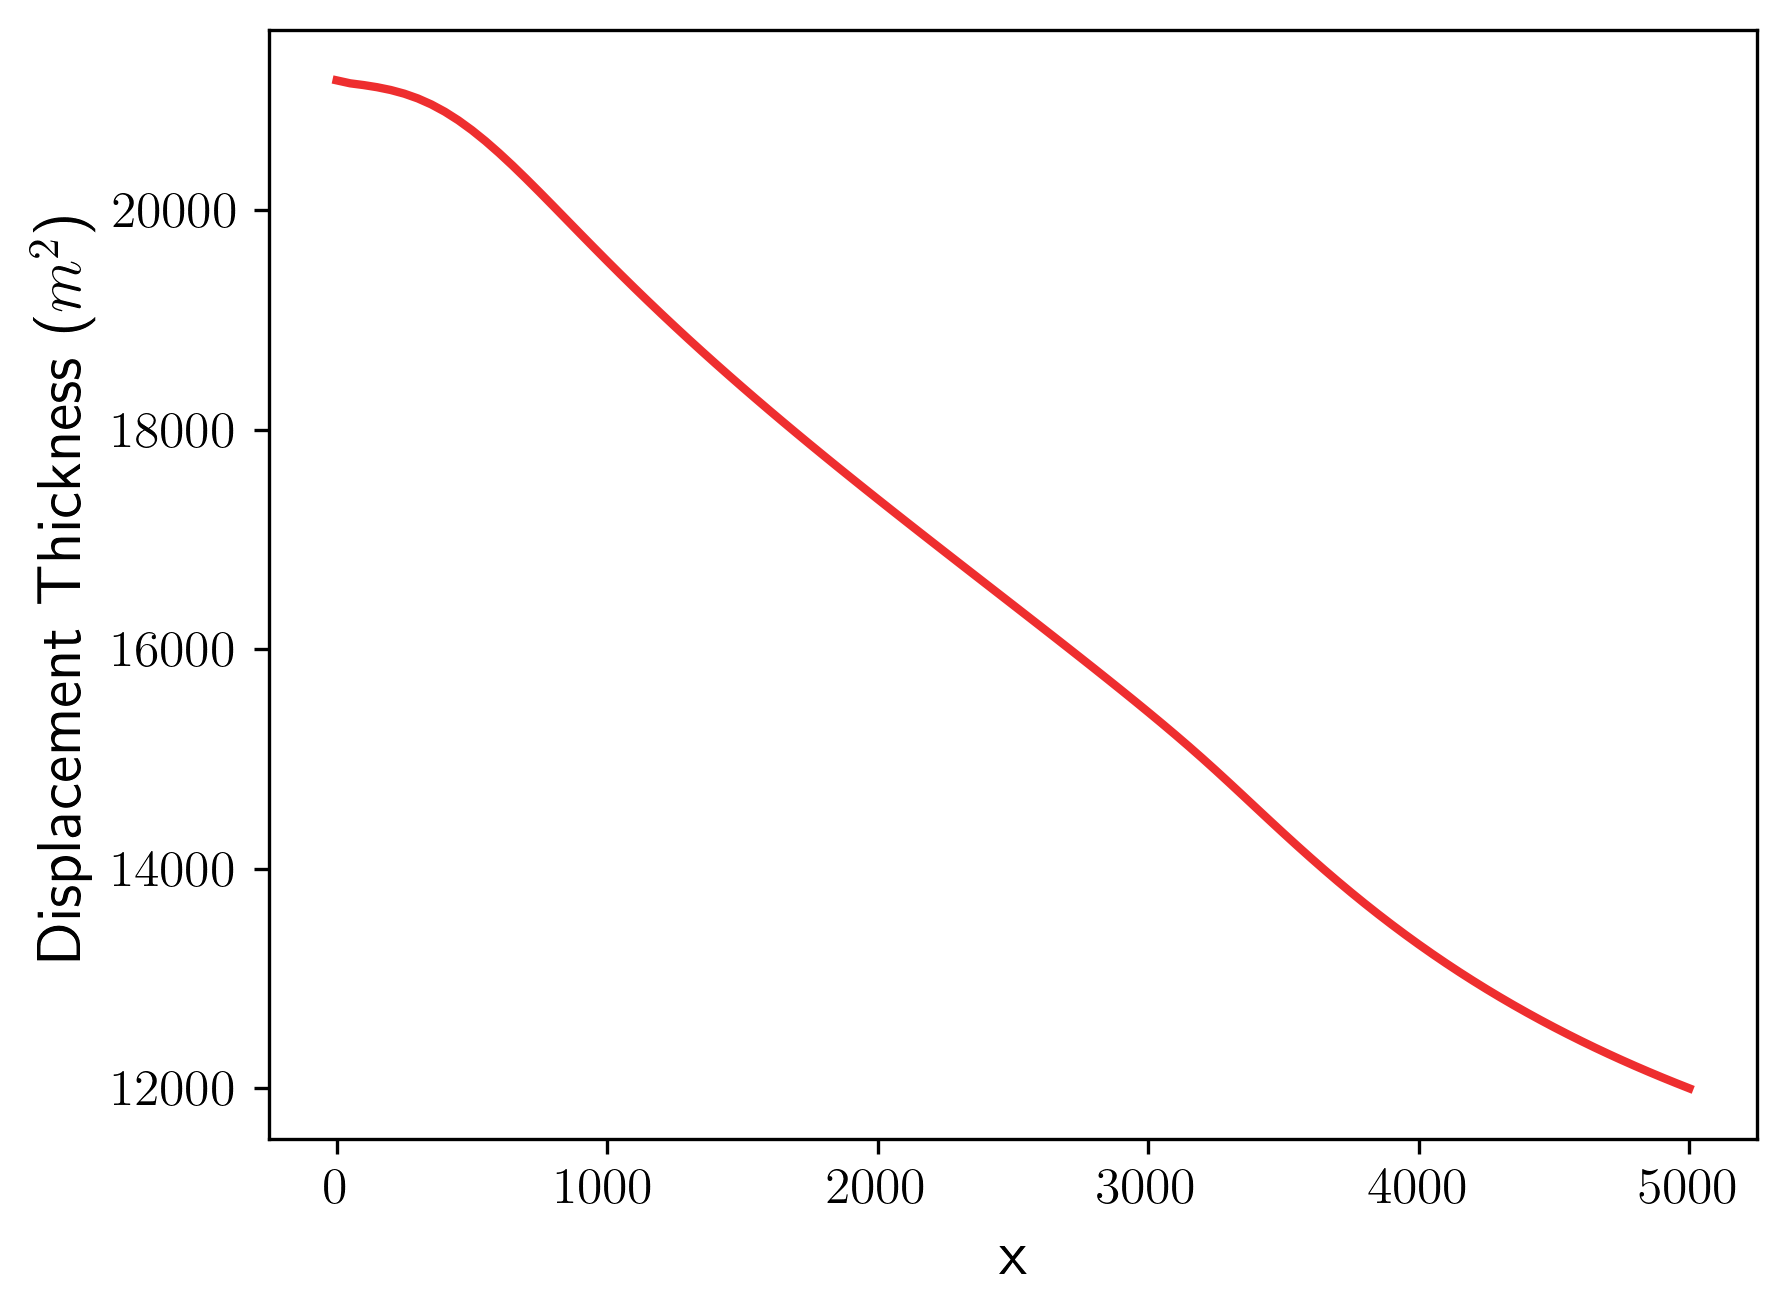

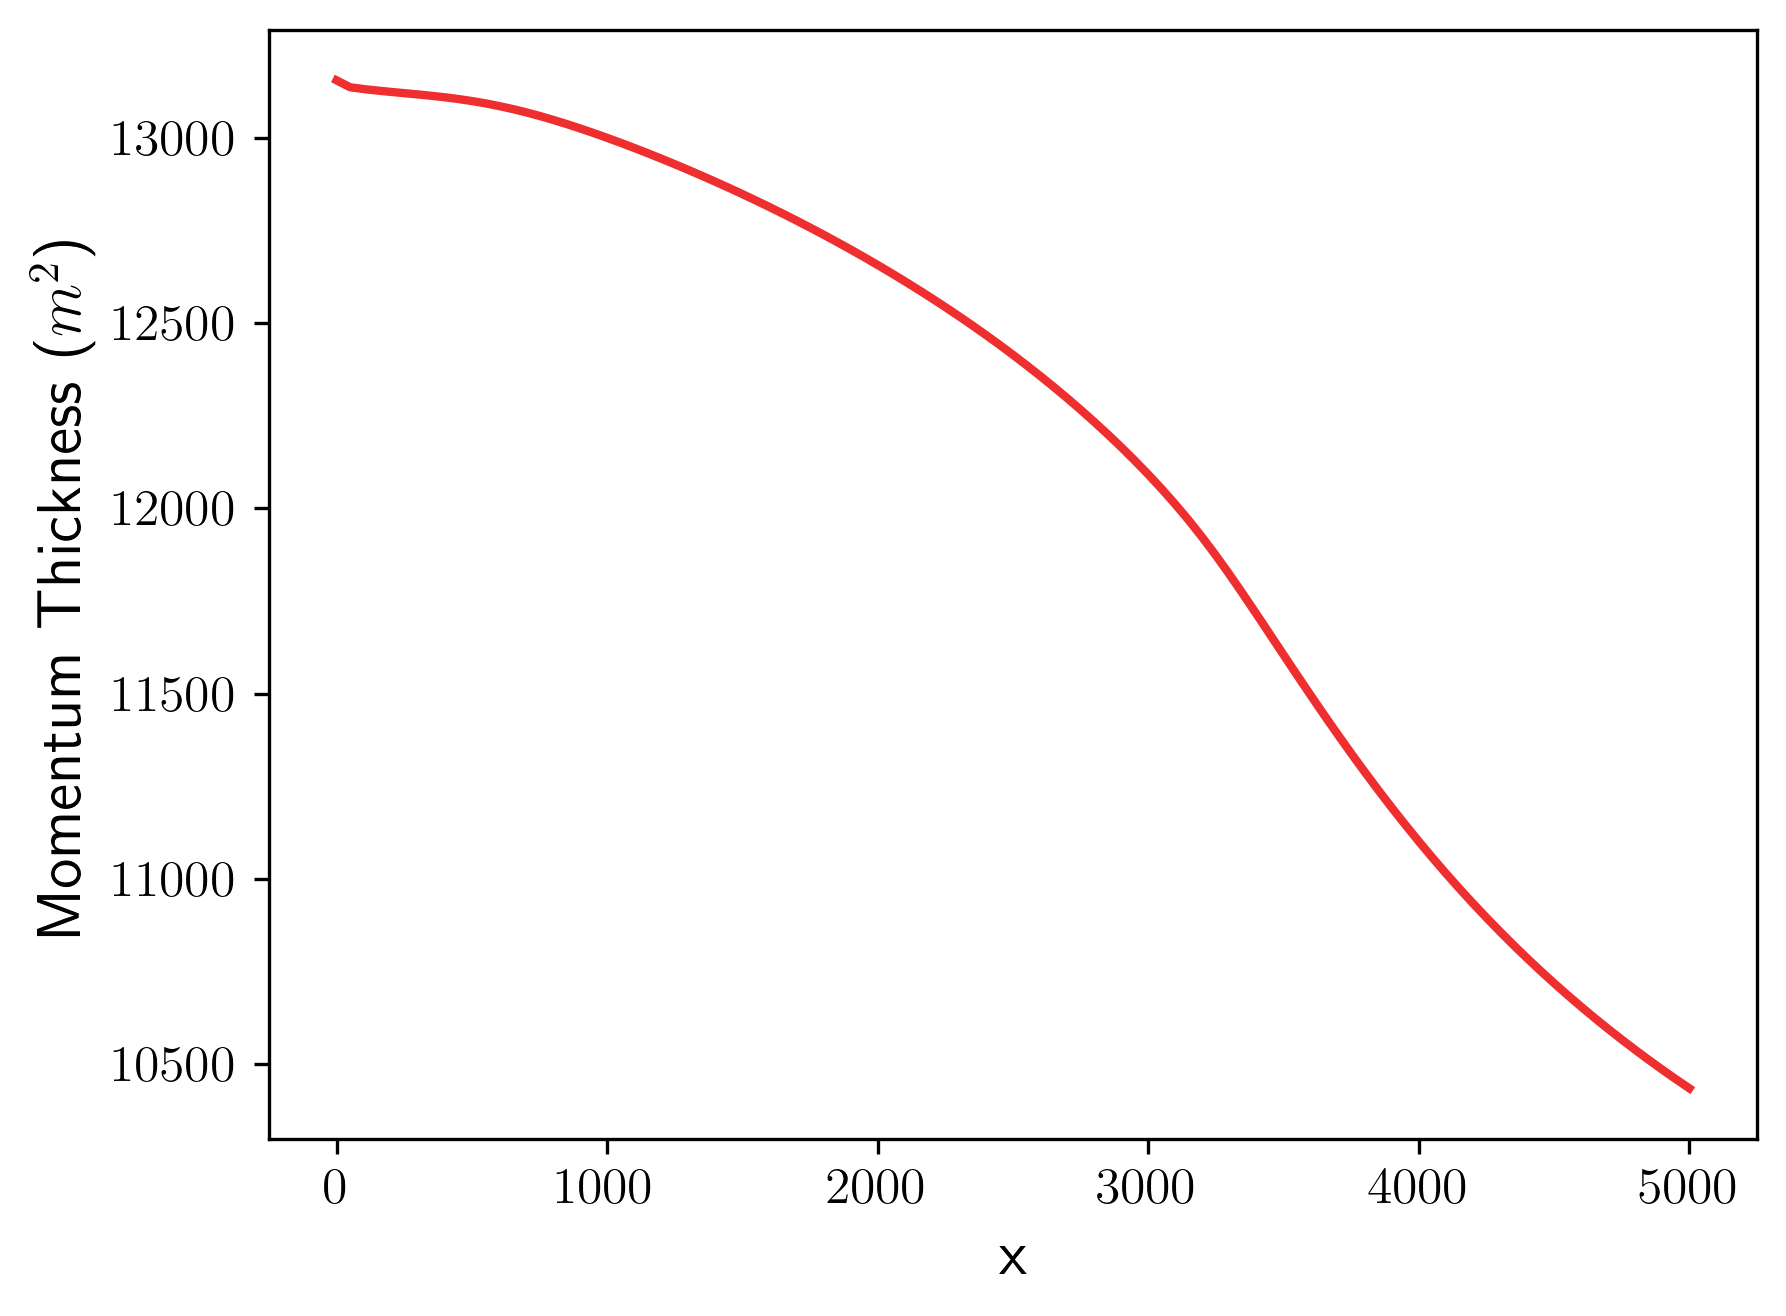

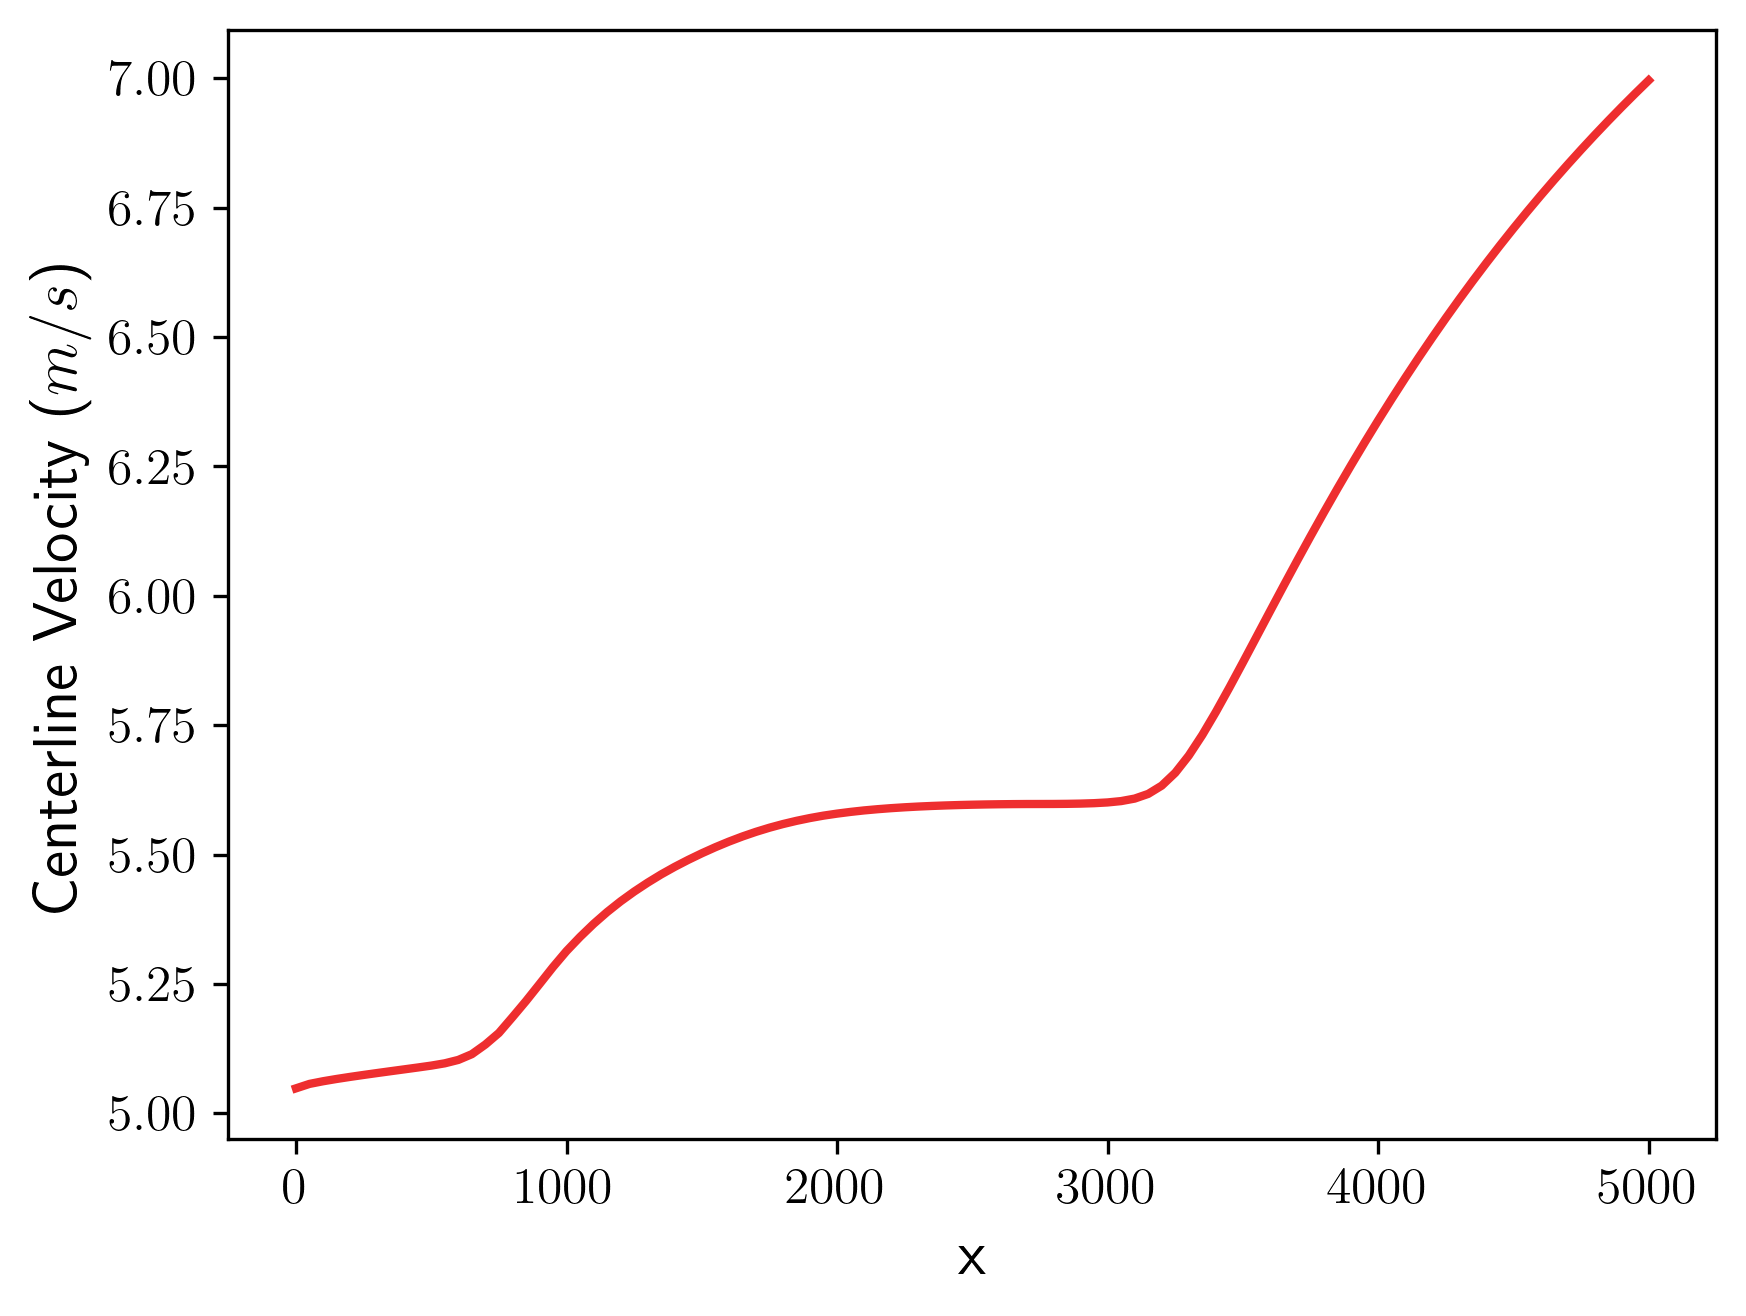

In [3]:
# Gather calibration outputs, currently wake thickness, centerline velocity
x_outputs = xvec[::5]
wake_stats = np.empty((len(x_outputs), 4))
for i, x in enumerate(x_outputs):
    wake_stats[i, 0] = x
    idx = np.searchsorted(xvec, x)
    wake_stats[i, 1] = SANDLST.calcDeltaThick(uarrayNOFCS[idx, :], Uinf, rvec) # wake displacement
    wake_stats[i, 2] = SANDLST.calcDeltaMom(uarrayNOFCS[idx, :], Uinf, rvec) # wake momentum thickness
    wake_stats[i, 3] = np.min(uarrayNOFCS[idx, :]) # center line velocity

# Plot QOIs
plt.figure()
plt.plot(x_outputs, wake_stats[:,1] * 2 * np.pi)
plt.xlabel('x')
plt.ylabel(r'Displacement Thickness ($m^2$)')
plt.figure()
plt.plot(x_outputs, wake_stats[:,2] * 2 * np.pi)
plt.xlabel('x')
plt.ylabel(r'Momentum Thickness ($m^2$)')
plt.figure()
plt.plot(x_outputs, wake_stats[:,3])
plt.xlabel('x')
plt.ylabel(r'Centerline Velocity ($m/s$)')

Text(0, 0.5, 'r/D')

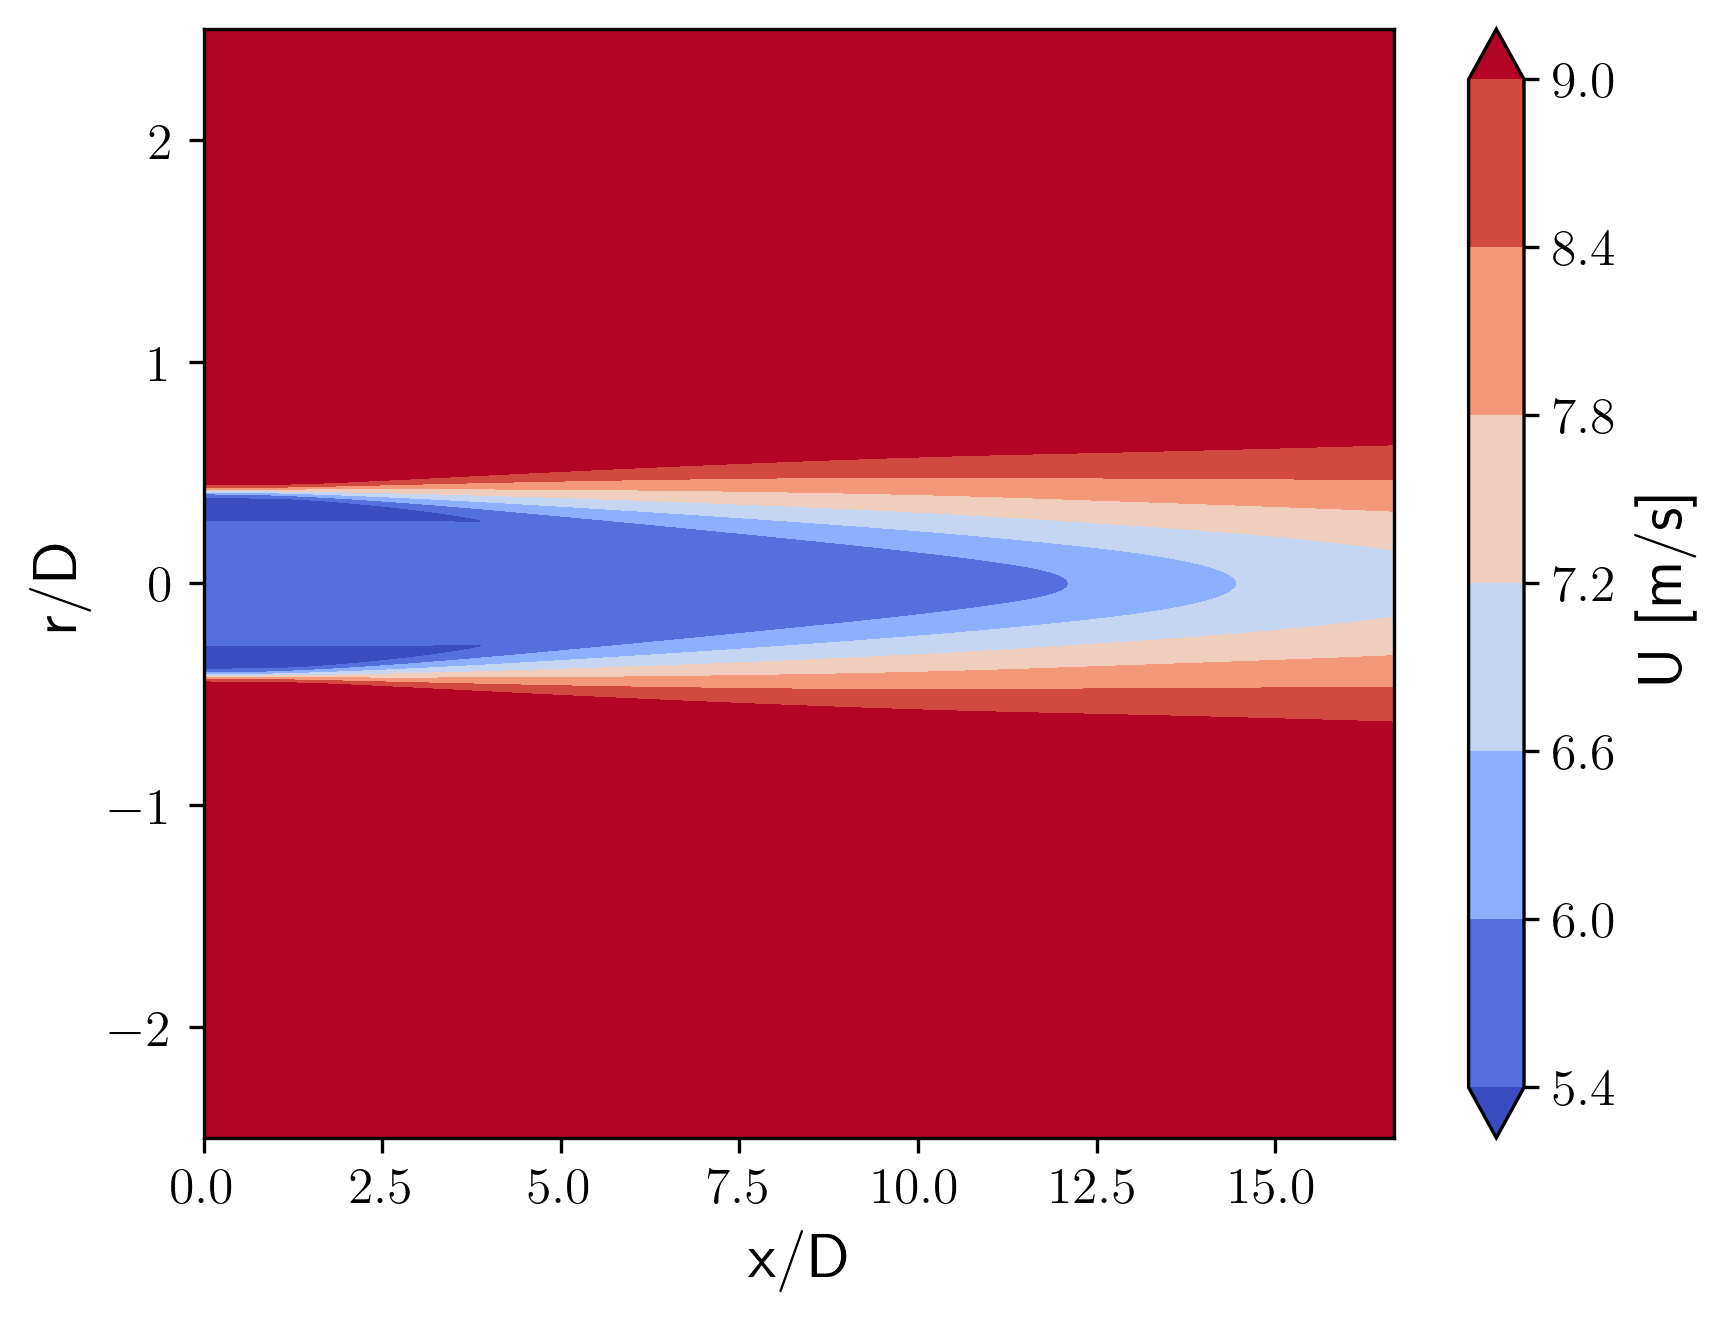

In [4]:
# Plot the wake profile
xm, rm = np.meshgrid(xvec, rvec)
xbig = np.concatenate([xm, xm], axis=0)
rbig = np.concatenate([-np.flipud(rm), rm], axis=0)
ubig = np.concatenate([np.flipud(uarrayNOFCS.T), uarrayNOFCS.T], axis = 0)
c0=plt.contourf(xbig/(2*ri[-1]), rbig/(2*ri[-1]), ubig, cmap='coolwarm', extend='both')
cbar = plt.colorbar(c0)
cbar.set_label('U [m/s]')

plt.xlabel('x/D')
plt.ylabel('r/D')